<a href="https://colab.research.google.com/github/Akkki28/PPOvsSAC/blob/main/PPOvsSAC_Slide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gymnasium

In [2]:
!pip install gymnasium_robotics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.1/26.1 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 847.8/847.8 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 8.6 MB/s eta 0:00:00


In [3]:
!pip install stable_baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import gymnasium as gym
import gymnasium_robotics
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3 import PPO,SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy

In [5]:
log_dir = "./logs_PPO/"
os.makedirs(log_dir, exist_ok=True)

In [13]:
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np

class SaveOnBestTrainingRewardCallback(BaseCallback):
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [14]:
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

gym.register_envs(gymnasium_robotics)
env = gym.make('FetchSlideDense-v3')
env = Monitor(env, log_dir)
vec_env = make_vec_env(lambda: env, n_envs=1)

model1 = PPO("MultiInputPolicy",vec_env, verbose=1)
model1.learn(total_timesteps=25000,callback=callback)
model1.save("ppo")

Using cuda device
Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: -31.60
Saving new best model to ./logs_PPO/best_model.zip
Num timesteps: 2000
Best mean reward: -31.60 - Last mean reward per episode: -32.32
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -32.3    |
|    success_rate    | 0        |
| time/              |          |
|    fps             | 223      |
|    iterations      | 1        |
|    time_elapsed    | 9        |
|    total_timesteps | 2048     |
---------------------------------
Num timesteps: 3000
Best mean reward: -31.60 - Last mean reward per episode: -31.92
Num timesteps: 4000
Best mean reward: -31.60 - Last mean reward per episode: -32.46
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50           |
|    ep_rew_mean          | -32.5        |
|    success_rate         | 0            |
| time/ 

In [15]:
log_dir2 = "./logs_SAC/"
os.makedirs(log_dir2, exist_ok=True)

In [16]:
callback2 = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir2)

env2 = gym.make('FetchSlideDense-v3')
env2 = Monitor(env2, log_dir2)
vec_env2 = make_vec_env(lambda: env2, n_envs=1)

model2 = SAC("MultiInputPolicy",vec_env2, verbose=1)
model2.learn(total_timesteps=25000,callback=callback2)
model2.save("sac")

Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -30.5    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 93       |
|    time_elapsed    | 2        |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | -5.13    |
|    critic_loss     | 0.0771   |
|    ent_coef        | 0.971    |
|    ent_coef_loss   | -0.198   |
|    learning_rate   | 0.0003   |
|    n_updates       | 99       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -31.9    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 76       |
|    time_elapsed    | 5        |
|    total_timesteps | 400      |
| train/             |        

In [10]:
import matplotlib.pyplot as plt
import numpy as np
def moving_average(values, window):
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=50)
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()

In [11]:
def plot_results_both(log_folders, labels, title="Learning Curve"):
    fig = plt.figure(title)

    for log_folder, label in zip(log_folders, labels):
        x, y = ts2xy(load_results(log_folder), "timesteps")
        y = moving_average(y, window=50)
        x = x[len(x) - len(y) :]

        plt.plot(x, y, label=label)

    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.legend()
    plt.show()

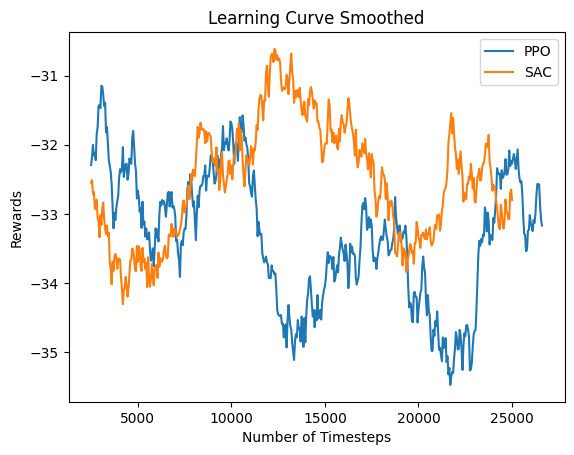

In [17]:
log_folders = ['/content/logs_PPO','/content/logs_SAC']
labels = ["PPO", "SAC"]
plot_results_both(log_folders, labels)